In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import FormatStrFormatter

import diffusionstuff7 as ds
from sim_handling import Simulation, multiple_test_avg_time

C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [2]:
#Meta testing parameters
number_of_tests = 10

In [3]:
# Graphics parameters
%matplotlib widget
ticklabelsize = 15
fontsize = 15
linewidth = 2
fignum = 0

In [ ]:
zero_d_test = Simulation(ds.f0d,shape=(1,), layermax=500, rtol=1e-12)
stats, avg_time = multiple_test_avg_time(zero_d_test.run, n_tests=number_of_tests)
print("Average time for 0D run: ", avg_time)
print('Other stats: ')
stats.strip_dirs().sort_stats("time").print_stats()

breaking because reached max number of layers grown


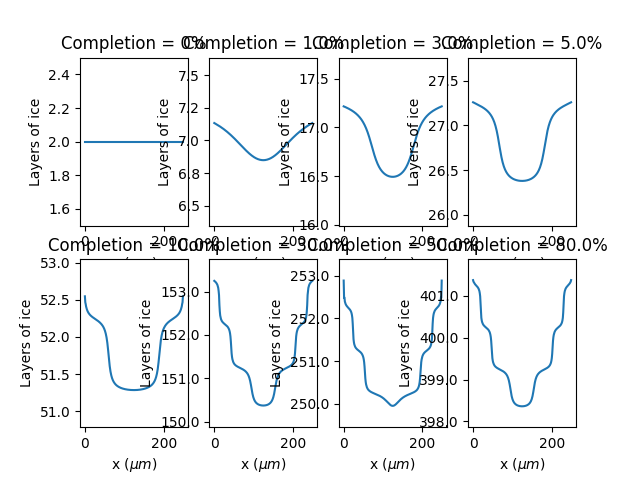

In [4]:
#qualitatively test output of 1d model
#plot the surface over time on subplots

one_d_test = Simulation(ds.f1d,shape=(250,), layermax=500, rtol=1e-12)

#run the simulation
ntot = one_d_test.getNtot()

fig, axs = plt.subplots(2, 4)
for i, cmpltion in enumerate([0,0.01,0.03,0.05,0.1,0.3,0.5,0.8]):

    xs = ntot[int(cmpltion*ntot.shape[0]),:]
    axs[i//4, i%4].set_xlabel(r'x ($\mu m$)')
    axs[i//4, i%4].set_ylabel('Layers of ice')
    axs[i//4, i%4].set_ylim(bottom=min(xs)-.5, top=max(xs)+.5)
    axs[i//4, i%4].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axs[i//4, i%4].set_title('Completion = '+str(cmpltion*100)+'%')
    axs[i//4, i%4].plot(xs, label='Completion = '+str(cmpltion*100)+'%')
plt.show()


In [ ]:
one_d_test = Simulation(ds.f1d,shape=(250,), layermax=500, rtol=1e-12)
stats, avg_time = multiple_test_avg_time(one_d_test.run, n_tests=number_of_tests)
print('Other stats: ')
stats.strip_dirs().sort_stats("time").print_stats()


In [ ]:
two_d_test = Simulation(ds.f2d, shape=(250,250), layermax=500, rtol=1e-12)
stats, avg_time = multiple_test_avg_time(two_d_test.run, n_tests=number_of_tests)
print('Other stats: ')
stats.strip_dirs().sort_stats("time").print_stats()